# Can we beat our original Q-Learner trader?

So we have shown that over a _specific_ time slice of the S&P 500 we can beat the market. Although that period of time was more about

In [1]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt

from collections import deque
from keras import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import random

import numpy as np
from util import create_df_benchmark, get_data
from marketsim import compute_portvals_single_symbol, market_simulator
from strategy import StrategyLearner
from analysis import get_portfolio_value, get_portfolio_stats
from keras.callbacks import EarlyStopping

Using TensorFlow backend.
/home/hexgnu/.pyenv/versions/3.7.3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
ACTION_TO_POSITION = {0: -1, 1: 0, 2: 1}

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9
        self.learning_rate = 0.001
        self.model = self._build_model()
    
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(60, input_dim=self.state_size, activation='relu'))
        model.add(Dense(60, activation='relu'))
        model.add(Dense(3, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            # return random.randrange(3) - 1 # Full bore buy or sell or hold
            return random.randrange(self.action_size)
        act_values = self.model.predict(np.asarray([state]))
        return np.argmax(act_values[0])  # returns action
    
    def _state_target(self, memory):
        states = []
        target_fs = []
        for state, action, reward, next_state, done in memory:
            target = reward
            if not done:
                target = reward + self.gamma * \
                         np.amax(self.model.predict(np.asarray([next_state]))[0])
            target_f = self.model.predict(np.asarray([state]))
            target_f[0][action] = target
            # target_f[0] = action * target
            states.append(state)
            target_fs.append(target_f)
        
        return (states, target_fs)
    
    def replay(self, validation_df=None):
        validation_memory = self.create_memory(validation_df, validation_df.index[-1], memory=[])
        
        v_states, v_target_fs = self._state_target(validation_memory)
        states, target_fs = self._state_target(self.memory)
        self.model.fit(np.asarray(states), np.asarray(target_fs)[:, 0, :], \
                       validation_data=(np.asarray(v_states),  np.asarray(v_target_fs)[:, 0, :]),
                       epochs=10, verbose=1)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def create_memory(self, df, end_date, memory=[]):
        for i, (d, r) in enumerate(df.iloc[self.state_size:-2].iterrows()):
            state = np.asarray(df.iloc[i:i+self.state_size]['SPY_ret'])
            action = ACTION_TO_POSITION[self.act(state)]
            next_state = np.asarray(df.iloc[i+1:i+self.state_size+1]['SPY_ret'])
            done = d == end_date
            reward = action * df.iloc[i+self.state_size]['SPY_ret']    
            memory.append((state, action, reward, next_state, done))
        
        return memory

In [3]:
train_start_date = dt.datetime(2007, 1, 1)
train_end_date   = dt.datetime(2007, 12, 31)
portfolio_start_date = dt.datetime(2008, 1, 1)
portfolio_end_date = dt.datetime(2008, 12, 31)

In [4]:
window_size = 10

training_df = get_data(['SPY'], pd.date_range(train_start_date, train_end_date), addSPY=False)
training_df['SPY_ret'] = training_df['SPY'].rolling(window=2).apply(lambda x: x[1] / x[0] - 1)
training_df = training_df.dropna()

validation_df = get_data(['SPY'], pd.date_range(portfolio_start_date, portfolio_end_date), addSPY=False)
validation_df['SPY_ret'] = validation_df['SPY'].rolling(window=2).apply(lambda x: x[1] / x[0] - 1)
validation_df = validation_df.dropna()

learner = DQNAgent(state_size=window_size, action_size=3)

for e in range(20):
    learner.memory = []
    learner.create_memory(training_df, train_end_date, memory=learner.memory)
    learner.replay(validation_df=validation_df)

Instructions for updating:
Colocations handled automatically by placer.


/home/hexgnu/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  after removing the cwd from sys.path.
/home/hexgnu/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  


Instructions for updating:
Use tf.cast instead.
Train on 238 samples, validate on 240 samples
Epoch 1/10
238/238 [==============================] - 0s 695us/step - loss: 3.2603e-05 - val_loss: 2.0913e-04
Epoch 2/10
238/238 [==============================] - 0s 71us/step - loss: 2.8478e-05 - val_loss: 2.1373e-04
Epoch 3/10
238/238 [==============================] - 0s 74us/step - loss: 2.6598e-05 - val_loss: 2.1561e-04
Epoch 4/10
238/238 [==============================] - 0s 70us/step - loss: 2.5301e-05 - val_loss: 2.2353e-04
Epoch 5/10
238/238 [==============================] - 0s 52us/step - loss: 2.4758e-05 - val_loss: 2.2329e-04
Epoch 6/10
238/238 [==============================] - 0s 53us/step - loss: 2.4987e-05 - val_loss: 2.1893e-04
Epoch 7/10
238/238 [==============================] - 0s 55us/step - loss: 2.4801e-05 - val_loss: 2.1812e-04
Epoch 8/10
238/238 [==============================] - 0s 55us/step - loss: 2.3884e-05 - val_loss: 2.2659e-04
Epoch 9/10
238/238 [=============

238/238 [==============================] - 0s 121us/step - loss: 1.3752e-05 - val_loss: 1.9594e-04
Train on 238 samples, validate on 240 samples
Epoch 1/10
238/238 [==============================] - 0s 61us/step - loss: 1.4524e-05 - val_loss: 2.4834e-04
Epoch 2/10
238/238 [==============================] - 0s 66us/step - loss: 1.3701e-05 - val_loss: 2.4522e-04
Epoch 3/10
238/238 [==============================] - 0s 110us/step - loss: 1.3386e-05 - val_loss: 2.4358e-04
Epoch 4/10
238/238 [==============================] - 0s 119us/step - loss: 1.5088e-05 - val_loss: 2.5001e-04
Epoch 5/10
238/238 [==============================] - 0s 108us/step - loss: 1.4950e-05 - val_loss: 2.3990e-04
Epoch 6/10
238/238 [==============================] - 0s 103us/step - loss: 1.2621e-05 - val_loss: 2.4974e-04
Epoch 7/10
238/238 [==============================] - 0s 136us/step - loss: 1.2440e-05 - val_loss: 2.5588e-04
Epoch 8/10
238/238 [==============================] - 0s 88us/step - loss: 1.2797e-05 -

238/238 [==============================] - 0s 45us/step - loss: 1.5679e-05 - val_loss: 2.7865e-04
Epoch 2/10
238/238 [==============================] - 0s 89us/step - loss: 1.5482e-05 - val_loss: 2.8134e-04
Epoch 3/10
238/238 [==============================] - 0s 103us/step - loss: 1.4622e-05 - val_loss: 2.7040e-04
Epoch 4/10
238/238 [==============================] - 0s 93us/step - loss: 1.4373e-05 - val_loss: 2.6666e-04
Epoch 5/10
238/238 [==============================] - 0s 151us/step - loss: 1.4093e-05 - val_loss: 2.7860e-04
Epoch 6/10
238/238 [==============================] - 0s 143us/step - loss: 1.3967e-05 - val_loss: 2.7713e-04
Epoch 7/10
238/238 [==============================] - 0s 140us/step - loss: 1.3819e-05 - val_loss: 2.6896e-04
Epoch 8/10
238/238 [==============================] - 0s 97us/step - loss: 1.3566e-05 - val_loss: 2.7514e-04
Epoch 9/10
238/238 [==============================] - 0s 135us/step - loss: 1.3082e-05 - val_loss: 2.6971e-04
Epoch 10/10
238/238 [====

In [5]:
learner.epsilon

0.12157665459056936

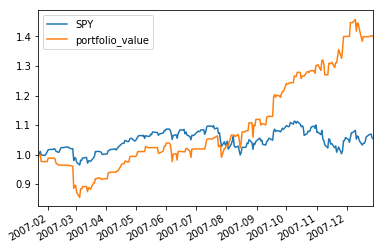

In [6]:
def analyze_portfolio(df):
    df_trades = {'trade': []}
    cum_return = 1

    for i, (d, r) in enumerate(df.iloc[learner.state_size:-2].iterrows()):
            state = np.asarray(df.iloc[i:i+learner.state_size]['SPY_ret'])
            position = learner.act(state)
            reward = position * df.iloc[i+learner.state_size+1]['SPY_ret']
            df_trades['trade'].append(position)
            cum_return *= 1+reward
            
    df_trades = pd.DataFrame(df_trades, index=df.index[learner.state_size+1:-1]).join(df)
    df_trades['portfolio_ret'] = (df_trades['trade'] * df_trades['SPY_ret'])
    df_trades['portfolio_value'] = (1 + df_trades['portfolio_ret']).cumprod()
    df_trades['SPY'] = df_trades['SPY'] / df_trades.iloc[0]['SPY']

    return df_trades

df_trades = analyze_portfolio(training_df)

df_trades[['SPY', 'portfolio_value']].plot()

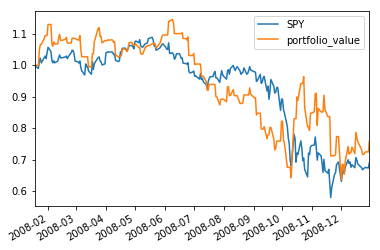

In [7]:
df_trades = analyze_portfolio(validation_df)
df_trades[['SPY', 'portfolio_value']].plot()

In [8]:
print ("\nPerformances during testing period for SPY")
print ("Date Range: {} to {}\n".format(validation_df.iloc[0].name, validation_df.iloc[-1].name))

from util import compute_sharpe_ratio
def get_sharpe(series):

    rfr = (1.03**(1/252.0))-1

    adr = series.mean()
    sddr = series.std()
    return compute_sharpe_ratio(np.sqrt(252), adr, rfr, sddr)

print("Sharpe Ratio of Portfolio: {}".format(get_sharpe(df_trades['portfolio_ret'])))
print("Sharpe Ratio of Benchmark: {}\n".format(get_sharpe(df_trades['SPY_ret'])))

print("Cumulative return of portfolio: {}".format((1+df_trades['portfolio_ret']).prod() - 1))
print("Cumulative return of benchmark: {}\n".format((1+df_trades['SPY_ret']).prod() - 1))

print("Standard Deviation of Portfolio: {}".format(df_trades['portfolio_ret'].std()))
print("Standard Deviation of Benchmark: {}\n".format(df_trades['SPY_ret'].std()))

print("Average Daily Return of Portfolio: {}".format(df_trades['portfolio_ret'].mean()))
print("Average Daily Return of Benchmark: {}\n".format(df_trades['SPY_ret'].mean()))

print("Final Portfolio Value: {}".format(100_000 * df_trades.iloc[-1]['portfolio_value']))
print("Final Benchmark Value: {}".format(100_000 * (1+df_trades['SPY_ret']).cumprod().iloc[-1]))


Performances during testing period for SPY
Date Range: 2008-01-03 00:00:00 to 2008-12-31 00:00:00

Sharpe Ratio of Portfolio: -0.26479797210914363
Sharpe Ratio of Benchmark: -0.8124472725772371

Cumulative return of portfolio: -0.2404962893753808
Cumulative return of benchmark: -0.3171693926193807

Standard Deviation of Portfolio: 0.03656621930412736
Standard Deviation of Benchmark: 0.026521696916875993

Average Daily Return of Portfolio: -0.0004926465788567073
Average Daily Return of Benchmark: -0.0012400599604033109

Final Portfolio Value: 75950.37106246191
Final Benchmark Value: 68283.06073806193
